# PyTorch Workflow

In [1]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.2.0'

## 1. Data (preparing and loading)

1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representations.

Linear Regression with known **parameters**

In [15]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
squeezed_X = torch.arange(start, end, step)
unsqueezed_X = squeezed_X.unsqueeze(dim=1) # add extra dim
y = weight * unsqueezed_X + bias

In [16]:
len(unsqueezed_X), len(y)

(50, 50)

### Splitting data

- **GOAL:** Generalization [to perform well on data it hasn't seen before]
    - Training set (ie: course materials)
    - Validation set (ie: practice exam)
    - Testing set (ie: final exam)

- There's a direct mapping of train input : test output

In [19]:
train_split_len = int(0.8 * len(unsqueezed_X))
train_split_len

40

In [20]:
X_train, y_train = unsqueezed_X[:train_split_len], y[:train_split_len]
len(X_train), len(y_train)

(40, 40)

In [21]:
X_test, y_test = unsqueezed_X[train_split_len:], y[train_split_len:]
len(X_test), len(y_test)

(10, 10)

How might we better visualize out data?

In [26]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    """Plots training data, test data, and compares predictions"""

    plt.figure(figsize=(5, 5))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    plt.legend(prop={"size": 14})

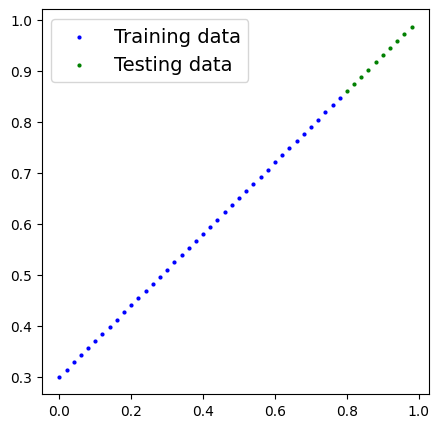

In [27]:
plot_predictions()